# MNIST Flow Matching (JAX Version)

This notebook demonstrates conditional flow matching on MNIST using JAX/Flax.

We implement:
* Optimal Transport CFM (OT-CFM)
* Schrödinger Bridge CFM (SF2M)


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from diffrax import diffeqsolve, ODETerm, Tsit5, Euler, SaveAt
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from jaxcfm.conditional_flow_matching import *
from jaxcfm.models.unet.unet import create_unet_model

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)


In [2]:
batch_size = 128
n_epochs = 3

# Load MNIST dataset (using torchvision for compatibility)
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


## Optimal Transport CFM


In [3]:
#################################
#            OT-CFM
#################################

sigma = 0.0
learning_rate = 1e-4

# Initialize model
key = random.PRNGKey(42)
from jaxcfm.models.unet.unet import create_unet_model
model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    class_cond=False
)

# Initialize model parameters
key, subkey = random.split(key)
dummy_t = jnp.array([0.5])
dummy_x = jnp.ones((batch_size, 1, 28, 28))
params = model.init(subkey, dummy_t, dummy_x)

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Initialize flow matcher
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)


In [4]:
# Training step function
@jax.jit
def train_step(params, opt_state, x1, key):
    key, subkey1, subkey2 = random.split(key, 3)
    # Sample noise
    x0 = random.normal(subkey1, x1.shape)
    
    # Sample location and conditional flow
    t, xt, ut = FM.sample_location_and_conditional_flow(subkey2, x0, x1)
    
    def loss_fn(params):
        # Model forward pass
        vt = model.apply(params, t, xt)
        loss = jnp.mean((vt - ut) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss, key

# Training loop
print("Training OT-CFM...")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        # Convert to JAX arrays
        x1_torch = data[0]  # Shape: (batch_size, 1, 28, 28)
        x1 = jnp.asarray(x1_torch.numpy())
        
        key, subkey = random.split(key)
        params, opt_state, loss, key = train_step(params, opt_state, x1, subkey)
        
        if (i + 1) % 100 == 0:
            print(f"epoch: {epoch}, step: {i+1}, loss: {loss:.4f}")


Training OT-CFM...


0it [00:00, ?it/s]

102it [00:30, 10.74it/s]

epoch: 0, step: 100, loss: 0.4683


202it [00:39, 11.57it/s]

epoch: 0, step: 200, loss: 0.3797


303it [00:47, 13.15it/s]

epoch: 0, step: 300, loss: 0.3360


403it [00:56, 11.12it/s]

epoch: 0, step: 400, loss: 0.2995


468it [01:02,  7.50it/s]
102it [00:09, 11.53it/s]

epoch: 1, step: 100, loss: 0.2831


203it [00:17, 12.39it/s]

epoch: 1, step: 200, loss: 0.2519


303it [00:25, 11.15it/s]

epoch: 1, step: 300, loss: 0.2403


403it [00:34, 11.14it/s]

epoch: 1, step: 400, loss: 0.2558


468it [00:40, 11.53it/s]
102it [00:08, 12.55it/s]

epoch: 2, step: 100, loss: 0.2303


202it [00:16, 11.40it/s]

epoch: 2, step: 200, loss: 0.2563


302it [00:25, 11.47it/s]

epoch: 2, step: 300, loss: 0.2501


402it [00:34, 11.55it/s]

epoch: 2, step: 400, loss: 0.2295


468it [00:39, 11.78it/s]


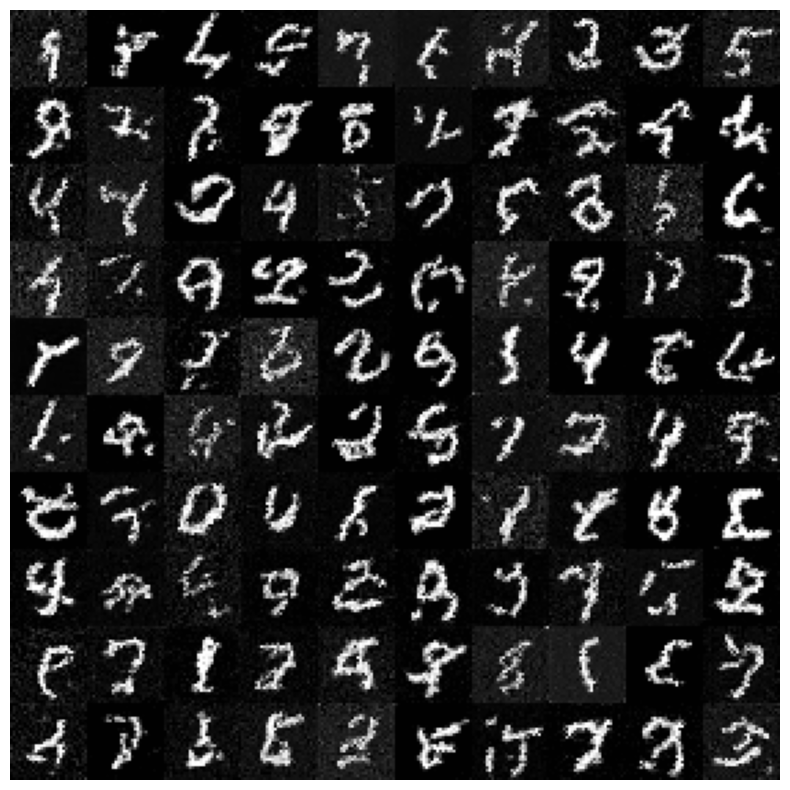

In [5]:
# Generate samples using ODE solver
key, subkey = random.split(key)
x0_init = random.normal(subkey, (100, 1, 28, 28))

# Define vector field for ODE
def vector_field(t, y, args):
    """Vector field for ODE: dx/dt = v_t(x)"""
    t_batch = jnp.full((y.shape[0],), t)
    return model.apply(params, t_batch, y)

term = ODETerm(vector_field)
solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, 2))

# Solve ODE
solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=x0_init, saveat=saveat)
traj = solution.ys  # Shape: (2, 100, 1, 28, 28)

# Convert to numpy for visualization
traj_np = np.array(traj[-1])  # Last time step
traj_np = np.clip(traj_np, -1, 1)

# Create grid using torchvision's make_grid (for compatibility)
traj_torch = torch.from_numpy(traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


## Schrödinger Bridge CFM (SF2M)


In [6]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1

# Initialize models (flow and score)
key = random.PRNGKey(42)
model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    class_cond=False
)
score_model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    class_cond=False
)

# Initialize parameters
key, subkey1, subkey2 = random.split(key, 3)
dummy_t = jnp.array([0.5])
dummy_x = jnp.ones((batch_size, 1, 28, 28))
params = model.init(subkey1, dummy_t, dummy_x)
score_params = score_model.init(subkey2, dummy_t, dummy_x)

# Combine parameters for joint optimization
combined_params = {'model': params, 'score_model': score_params}

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(combined_params)

# Initialize flow matcher
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)


In [7]:
# Training step for SF2M
@jax.jit
def train_step_sf2m(combined_params, opt_state, x1, key):
    key, subkey1, subkey2 = random.split(key, 3)
    # Sample noise
    x0 = random.normal(subkey1, x1.shape)
    
    # Sample location and conditional flow (with noise for score loss)
    t, xt, ut, eps = FM.sample_location_and_conditional_flow(subkey2, x0, x1, return_noise=True)
    
    lambda_t = FM.compute_lambda(t)
    
    def loss_fn(combined_params):
        # Flow model forward pass
        vt = model.apply(combined_params['model'], t, xt)
        # Score model forward pass
        st = score_model.apply(combined_params['score_model'], t, xt)
        
        flow_loss = jnp.mean((vt - ut) ** 2)
        score_loss = jnp.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
        loss = flow_loss + score_loss
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(combined_params)
    updates, opt_state = optimizer.update(grads, opt_state, combined_params)
    combined_params = optax.apply_updates(combined_params, updates)
    
    return combined_params, opt_state, loss, key

# Training loop
print("Training SF2M...")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        # Convert to JAX arrays
        x1_torch = data[0]
        x1 = jnp.asarray(x1_torch.numpy())
        
        key, subkey = random.split(key)
        combined_params, opt_state, loss, key = train_step_sf2m(combined_params, opt_state, x1, subkey)
        
        if (i + 1) % 100 == 0:
            print(f"epoch: {epoch}, step: {i+1}, loss: {loss:.4f}")


Training SF2M...


100it [00:38, 10.10it/s]

epoch: 0, step: 100, loss: 1.6491


200it [00:56,  4.64it/s]

epoch: 0, step: 200, loss: 1.4695


300it [01:13,  4.77it/s]

epoch: 0, step: 300, loss: 1.3798


400it [01:30,  4.73it/s]

epoch: 0, step: 400, loss: 1.3511


468it [01:41,  4.62it/s]
100it [00:17,  4.71it/s]

epoch: 1, step: 100, loss: 1.3077


200it [00:33,  5.19it/s]

epoch: 1, step: 200, loss: 1.2992


300it [00:50,  4.66it/s]

epoch: 1, step: 300, loss: 1.2629


400it [01:07,  4.80it/s]

epoch: 1, step: 400, loss: 1.2912


468it [01:18,  5.93it/s]
101it [00:16,  8.29it/s]

epoch: 2, step: 100, loss: 1.2610


200it [00:34,  4.59it/s]

epoch: 2, step: 200, loss: 1.2703


300it [00:50,  4.64it/s]

epoch: 2, step: 300, loss: 1.2769


400it [01:08,  4.61it/s]

epoch: 2, step: 400, loss: 1.2627


468it [01:19,  5.90it/s]
100it [00:17,  4.63it/s]

epoch: 3, step: 100, loss: 1.2745


200it [00:34,  4.67it/s]

epoch: 3, step: 200, loss: 1.2703


300it [00:51,  4.59it/s]

epoch: 3, step: 300, loss: 1.3171


400it [01:08,  4.62it/s]

epoch: 3, step: 400, loss: 1.2457


468it [01:20,  5.80it/s]
100it [00:16,  4.60it/s]

epoch: 4, step: 100, loss: 1.2605


200it [00:34,  4.54it/s]

epoch: 4, step: 200, loss: 1.2293


300it [00:51,  4.58it/s]

epoch: 4, step: 300, loss: 1.2285


400it [01:08,  4.62it/s]

epoch: 4, step: 400, loss: 1.3188


468it [01:19,  5.87it/s]
100it [00:17,  4.61it/s]

epoch: 5, step: 100, loss: 1.2868


200it [00:34,  4.59it/s]

epoch: 5, step: 200, loss: 1.2318


300it [00:52,  4.63it/s]

epoch: 5, step: 300, loss: 1.2217


400it [01:08,  4.59it/s]

epoch: 5, step: 400, loss: 1.3636


468it [01:20,  5.80it/s]
100it [00:16,  4.66it/s]

epoch: 6, step: 100, loss: 1.2152


200it [00:34,  4.61it/s]

epoch: 6, step: 200, loss: 1.2090


300it [00:51,  4.65it/s]

epoch: 6, step: 300, loss: 1.2372


400it [01:08,  4.60it/s]

epoch: 6, step: 400, loss: 1.2214


468it [01:19,  5.87it/s]
100it [00:17,  4.62it/s]

epoch: 7, step: 100, loss: 1.2200


200it [00:34,  4.64it/s]

epoch: 7, step: 200, loss: 1.2013


300it [00:52,  4.59it/s]

epoch: 7, step: 300, loss: 1.2258


400it [01:08,  4.63it/s]

epoch: 7, step: 400, loss: 1.2360


468it [01:20,  5.81it/s]
100it [00:16,  4.65it/s]

epoch: 8, step: 100, loss: 1.2224


200it [00:34,  4.67it/s]

epoch: 8, step: 200, loss: 1.2351


300it [00:51,  4.63it/s]

epoch: 8, step: 300, loss: 1.2200


400it [01:08,  4.65it/s]

epoch: 8, step: 400, loss: 1.2313


468it [01:19,  5.87it/s]
100it [00:17,  4.63it/s]

epoch: 9, step: 100, loss: 1.2314


200it [00:34,  4.62it/s]

epoch: 9, step: 200, loss: 1.1903


300it [00:51,  4.62it/s]

epoch: 9, step: 300, loss: 1.2189


400it [01:08,  4.57it/s]

epoch: 9, step: 400, loss: 1.2414


468it [01:20,  5.82it/s]


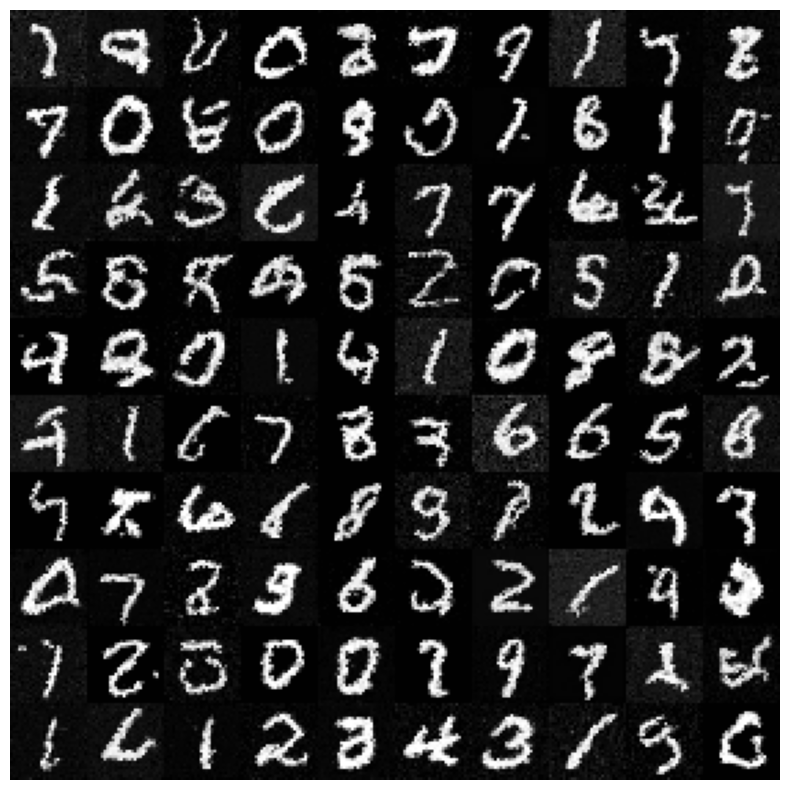

In [8]:
# Generate samples using ODE solver (Euler method for faster generation)
key, subkey = random.split(key)
x0_init = random.normal(subkey, (100, 1, 28, 28))

# Define vector field
def vector_field(t, y, args):
    t_batch = jnp.full((y.shape[0],), t)
    return model.apply(combined_params['model'], t_batch, y)

term = ODETerm(vector_field)
solver = Euler()  # Use Euler for faster generation
saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, 1000))  # More steps for Euler

# Solve ODE
solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.001, y0=x0_init, saveat=saveat)
traj = solution.ys

# Convert to numpy for visualization
traj_np = np.array(traj[-1])
traj_np = np.clip(traj_np, -1, 1)

# Create grid
traj_torch = torch.from_numpy(traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


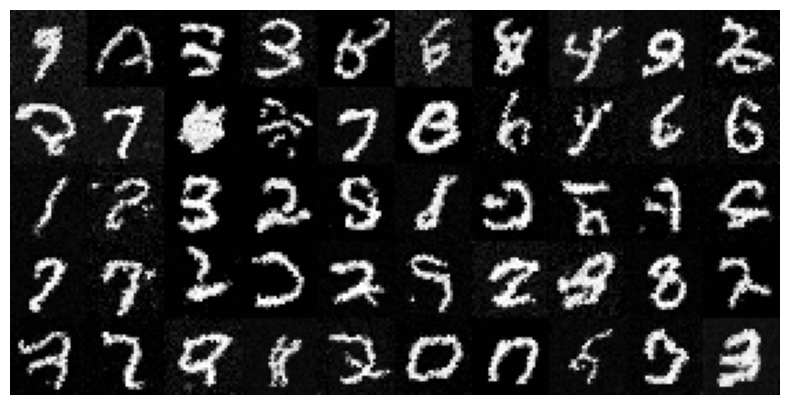

In [9]:
# SDE generation using Euler-Maruyama method
# Simple SDE solver for JAX (Ito SDE: dx = f(t,x)dt + g(t,x)dW)

def euler_maruyama_sde(f, g, x0, ts, key, dt=0.01):
    """
    Solve SDE: dx = f(t, x)dt + g(t, x)dW using Euler-Maruyama method.
    
    Parameters
    ----------
    f : callable, drift function f(t, x) -> dx/dt
    g : callable, diffusion function g(t, x) -> diffusion coefficient
    x0 : initial condition
    ts : time points
    key : JAX PRNG key
    dt : time step
    
    Returns
    -------
    trajectory : array of shape (len(ts), *x0.shape)
    """
    trajectory = [x0]
    x = x0
    t = ts[0]
    key, subkey = random.split(key)
    
    for i in range(len(ts) - 1):
        t_curr = ts[i]
        t_next = ts[i + 1]
        
        # Drift term
        drift = f(t_curr, x) * dt
        
        # Diffusion term (Brownian motion increment)
        key, subkey = random.split(key)
        dW = random.normal(subkey, x.shape) * jnp.sqrt(dt)
        diffusion = g(t_curr, x) * dW
        
        # Euler-Maruyama step
        x = x + drift + diffusion
        trajectory.append(x)
        t = t_next
    
    return jnp.stack(trajectory)

# Define SDE drift and diffusion
def drift_fn(t, y):
    """Drift: f(t, y) = v_t(y) + s_t(y)"""
    y_reshaped = y.reshape(-1, 1, 28, 28)
    t_batch = jnp.full((y_reshaped.shape[0],), t)
    v = model.apply(combined_params['model'], t_batch, y_reshaped)
    s = score_model.apply(combined_params['score_model'], t_batch, y_reshaped)
    return (v + s).reshape(-1, 1 * 28 * 28)

def diffusion_fn(t, y):
    """Diffusion: g(t, y) = sigma"""
    return jnp.ones_like(y) * sigma

# Generate samples using SDE
key, subkey = random.split(key)
x0_sde = random.normal(subkey, (50, 1 * 28 * 28))  # Flattened for SDE
ts = jnp.linspace(0.0, 1.0, int(1.0 / 0.01) + 1)

sde_traj = euler_maruyama_sde(drift_fn, diffusion_fn, x0_sde, ts, key, dt=0.01)

# Reshape and visualize
sde_traj_reshaped = sde_traj[-1].reshape(50, 1, 28, 28)
sde_traj_np = np.array(sde_traj_reshaped)
sde_traj_np = np.clip(sde_traj_np, -1, 1)

# Create grid (note: only 50 samples, so 5x10 grid)
traj_torch = torch.from_numpy(sde_traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()
